# Portada

In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('rpi_data_processed.csv')

# Initialize dataframe df_rates
df_rates = df.drop(['Ping (ms)', 'Date', 'Time'], axis=1)

# Rename the download and
# upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping (ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [4]:
df_rates.describe()

,upload_rate,download_rate,ping_rate
count,673.000000,673.000000,673.000000
mean,13.697608,90.449212,48.657348
std,1.080471,3.465647,6.030512
min,6.210000,58.480000,13.067113
25%,13.640000,90.220000,45.781257
50%,13.980000,91.560000,49.207755
75%,14.180000,92.070000,52.314936
max,14.550000,92.870000,61.854395


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [6]:
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

In [7]:
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))

interactive(children=(IntSlider(value=45, description='azim', max=90), IntSlider(value=45, description='elev',…

<function __main__.<lambda>(azim, elev)>

## Parte 2: Detección de anomalías euclidiana

#### Paso 1: Calcular los promedios

In [8]:
mu = df_rates.mean()

#### Paso 2: Calcular la distancia euclidiana

In [11]:
euclid_sq = np.square(df_rates-mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)

#### Paso 3: Crear un histograma

Text(0, 0.5, 'Relative frequency')

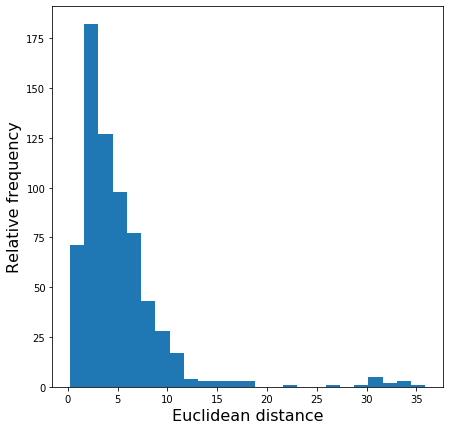

In [12]:
fig = plt.figure(figsize=(7, 7))
plt.hist(euclid,25)
plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)

#### Paso 4: Calcular la distancia normalizada

In [13]:
max_euclid = euclid.max() # Maximum Euclidean distance
nmd_euclid = [float(x)/max_euclid for x in euclid] # Normalized Euclidean distance

In [14]:
nmd_euclid

[0.3261426481744364,
 0.22912062171733033,
 0.8527782638568026,
 0.09471275451021244,
 0.12573253912613044,
 0.2325144714882455,
 0.09371651587836158,
 0.04657273013096377,
 0.08983263310896522,
 0.06331312969212052,
 0.11833063576397744,
 0.19156755250481747,
 0.18437773978457464,
 0.1769334936347002,
 0.1692348031245933,
 0.216349548194818,
 0.10452582927568589,
 0.032174302004333404,
 0.08982542123378812,
 0.48073610309330356,
 0.10446244546308106,
 0.09029435624567007,
 0.091249530722368,
 0.05283835220986438,
 0.27152480024324727,
 0.06569229263383833,
 0.04419712976928012,
 0.32209144439197346,
 0.03479753442904321,
 0.12778935106915879,
 0.16598292409319884,
 0.1075329161653475,
 0.13964674289754178,
 0.2261696226451734,
 0.1254144743348412,
 0.24595253283970828,
 0.1338811286944561,
 0.12832730626679928,
 0.11058922906706517,
 0.13269849899571437,
 0.060028099959014425,
 0.15234292282468795,
 0.14849339158232513,
 0.20890872662383,
 0.1411991452403835,
 0.060008652039402983,
 0

#### Paso 5: Visualizar el índice de alarmas

In [17]:
ecl_alarm_rate = []
nmd_range = np.linspace(0, 1, 400)
for nmd_decision in nmd_range:
    num_fail = (nmd_euclid > nmd_decision).sum()
    ecl_alarm_rate.append(float(num_fail)/len(euclid))

Text(0, 0.5, 'Alarm rate')

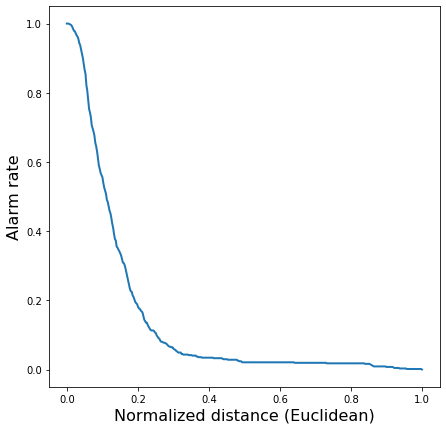

In [18]:
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

#### Paso 6: Seleccionar el límite de decisión

In [20]:
threshold = 0.1
index,ecl_threshold = next(tpl for tpl in enumerate(ecl_alarm_rate) if tpl[1]<threshold)
ecl_decision = nmd_range[index]

#### Paso 7: Visualizar el límite de decisión

Text(0, 0.5, 'Alarm rate')

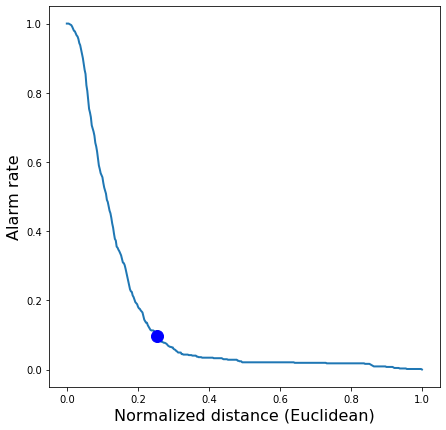

In [22]:
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.plot(ecl_decision, ecl_threshold, 'bo', markersize=12)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

#### Paso 8: Visualizar el límite de decisión en 3D

In [23]:
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Centre decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()

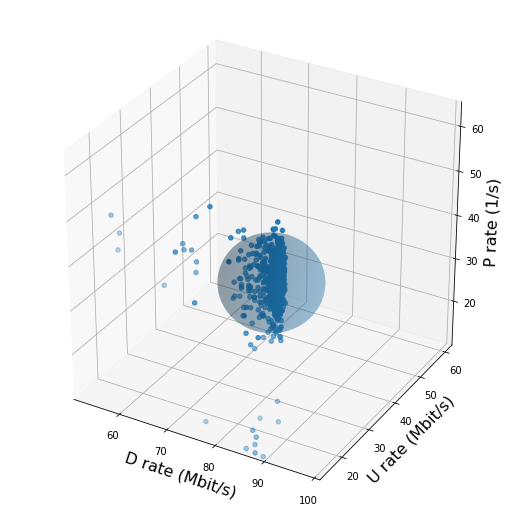

In [24]:
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);